In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 读取数据并提取收盘价
df = pd.read_csv(r'D:\Clion\code\20250526\data\Gold.csv')
close_prices = df['close'].values.reshape(-1, 1)

# 定义训练和预测长度
train_size = len(close_prices) - 5  # 预测未来5天
X = np.arange(len(close_prices)).reshape(-1, 1)  # 时间特征
y = close_prices.ravel()

# 归一化处理
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X[:train_size])
y_train_scaled = scaler_y.fit_transform(y[:train_size].reshape(-1, 1)).ravel()

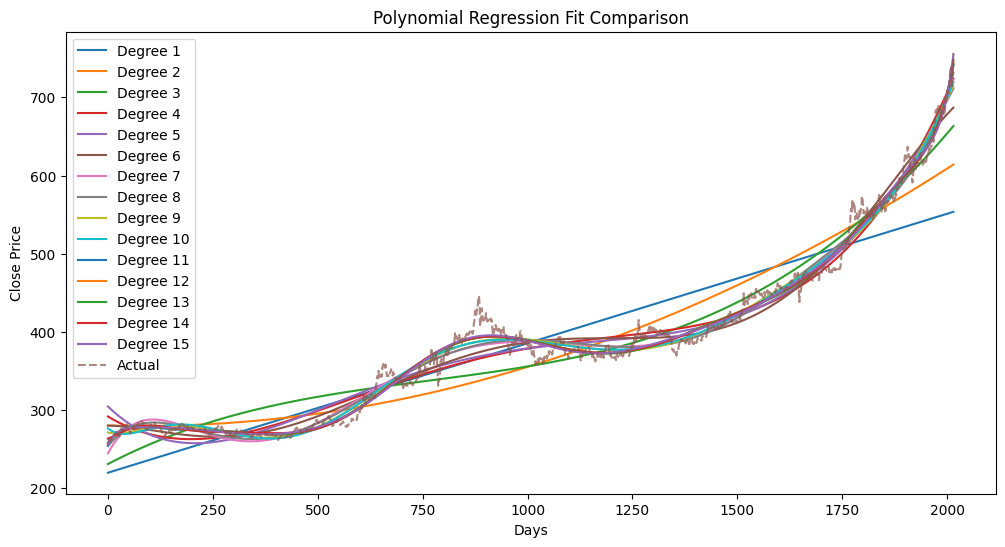

MSE对比：
Degree 1: 1820.11
Degree 2: 1087.34
Degree 3: 737.93
Degree 4: 322.44
Degree 5: 307.31
Degree 6: 260.07
Degree 7: 173.62
Degree 8: 168.38
Degree 9: 151.54
Degree 10: 150.16
Degree 11: 128.79
Degree 12: 128.59
Degree 13: 128.56
Degree 14: 127.47
Degree 15: 125.75


In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

degrees = list(range(1,16))
mse_scores = []
plt.figure(figsize=(12, 6))

for degree in degrees:
    # 生成多项式特征
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train_scaled)
    
    # 训练模型
    model = LinearRegression()
    model.fit(X_poly_train, y_train_scaled)
    
    # 预测并计算MSE
    y_train_pred = scaler_y.inverse_transform(
        model.predict(X_poly_train).reshape(-1, 1)
    ).ravel()
    mse = mean_squared_error(y[:train_size], y_train_pred)
    mse_scores.append(mse)
    
    # 绘制拟合曲线
    plt.plot(X[:train_size], y_train_pred, label=f'Degree {degree}')

plt.plot(X[:train_size], y[:train_size], label='Actual', linestyle='--', alpha=0.7)
plt.title('Polynomial Regression Fit Comparison')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

print("MSE对比：")
for degree, mse in zip(degrees, mse_scores):
    print(f"Degree {degree}: {mse:.2f}")

In [3]:
# 生成未来5天的时间特征
X_future = np.arange(len(close_prices), len(close_prices)+5).reshape(-1, 1)
X_future_scaled = scaler_X.transform(X_future)

# 使用最优模型预测
poly = PolynomialFeatures(degree=15)
X_poly_future = poly.fit_transform(X_future_scaled)
model = LinearRegression()
model.fit(poly.fit_transform(X_train_scaled), y_train_scaled)

y_future_scaled = model.predict(X_poly_future)
y_future_pred = scaler_y.inverse_transform(
    y_future_scaled.reshape(-1, 1)
).ravel()

print("未来5日预测值：", y_future_pred)

未来5日预测值： [782.62673109 787.89736916 793.33464338 798.94332406 804.72827046]


In [4]:
class ManualLinearRegression:
    def __init__(self):
        self.coef_ = None
    
    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # 添加截距项
        self.coef_ = np.linalg.inv(X.T @ X) @ X.T @ y
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return X @ self.coef_

# 测试手动实现
manual_model = ManualLinearRegression()
manual_model.fit(poly.fit_transform(X_train_scaled)[:, 1:], y_train_scaled)  # 忽略截距列
y_manual_pred = scaler_y.inverse_transform(
    manual_model.predict(X_poly_future[:, 1:]).reshape(-1, 1)
).ravel()
print("手动实现预测值：", y_manual_pred)

手动实现预测值： [713.77851185 716.73176854 719.7429794  722.81315348 725.94331242]


In [16]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# 定义模型
models = {
    'Ridge': Ridge(alpha=0.1),
    'Lasso': Lasso(alpha=0.0001),
    'ElasticNet': ElasticNet(alpha=0.0001, l1_ratio=0.5)
}

# 训练并预测
predictions = {}
for name, model in models.items():
    model.fit(poly.fit_transform(X_train_scaled), y_train_scaled)
    y_pred = scaler_y.inverse_transform(
        model.predict(X_poly_future).reshape(-1, 1)
    ).ravel()
    predictions[name] = y_pred

# 输出预测结果
for name, pred in predictions.items():
    print(f"{name}预测值：", pred)

Ridge预测值： [713.11408691 714.02384941 714.93271883 715.84065716 716.74762609]
Lasso预测值： [728.47866585 729.83619815 731.19909838 732.56738641 733.94108222]
ElasticNet预测值： [730.12790162 731.49041474 732.85816444 734.23116902 735.60944685]


In [6]:
from sklearn.neighbors import KNeighborsRegressor

# 训练KNN模型
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train_scaled)

# 预测未来5日
knn_pred_scaled = knn_model.predict(X_future_scaled)
knn_pred = scaler_y.inverse_transform(knn_pred_scaled.reshape(-1, 1)).ravel()
print("KNN预测值：", knn_pred)

KNN预测值： [731.744 731.744 731.744 731.744 731.744]


In [7]:
from sklearn.svm import SVR

# 训练SVR模型（核函数选择RBF）
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)

# 预测未来5日
svr_pred_scaled = svr_model.predict(X_future_scaled)
svr_pred = scaler_y.inverse_transform(svr_pred_scaled.reshape(-1, 1)).ravel()
print("SVR预测值：", svr_pred)

SVR预测值： [694.51685348 694.93757116 695.35619144 695.77270791 696.18711423]


In [8]:
from sklearn.ensemble import AdaBoostRegressor

# 训练AdaBoost模型（基模型为决策树）
ada_model = AdaBoostRegressor(n_estimators=50, random_state=42)
ada_model.fit(X_train_scaled, y_train_scaled)

# 预测未来5日
ada_pred_scaled = ada_model.predict(X_future_scaled)
ada_pred = scaler_y.inverse_transform(ada_pred_scaled.reshape(-1, 1)).ravel()
print("AdaBoost预测值：", ada_pred)

AdaBoost预测值： [706.03 706.03 706.03 706.03 706.03]


In [9]:
actual = np.array([804.11, 825.80, 786.99, 792.47, 785.60])
knn_error = np.mean(np.abs((knn_pred - actual) / actual)) * 100
# 其他方法误差计算
svr_error = np.mean(np.abs((svr_pred - actual) / actual)) * 100
ada_error = np.mean(np.abs((ada_pred - actual) / actual)) * 100
print(f"SVR平均误差率：{svr_error:.2f}%")
print(f"AdaBoost平均误差率：{ada_error:.2f}%")
print(f"KNN平均误差率：{knn_error:.2f}%")

SVR平均误差率：12.94%
AdaBoost平均误差率：11.60%
KNN平均误差率：8.39%
